### First step, we load the data

Functions for that purpose are contained in my_mnist_loader, and there is no need to go here into these details

In [1]:
from my_mnist_loader import *

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = my_load_data_wrapper()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

Now we define a DataSet and DataLoaders for each of the original datasets

DataSet and DataLoaders are PyTorch defined classes that make really easy to process data into our training loop

In [4]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        f = torch.tensor(self.features[index])
        l = torch.tensor(self.labels[index])
        return (f.to(device), l.to(device))

    def __len__(self):
        return len(self.labels)

In [5]:
# Create data loader
batch_size = 100
train_data = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_data = CustomDataset(X_val, y_val)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_data = CustomDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [6]:
def evaluate(model, dataset, max_ex=0):
    acc = 0
    N = len(dataset) * batch_size
    for i, (features, labels) in enumerate(dataset):
        scores = model(features)
        pred = torch.argmax(scores, dim=1)
        acc += torch.sum(torch.eq(pred, labels)).item()
        if max_ex != 0 and i >= max_ex:
            break
    # print(i)
    return (acc * 100 / ((i+1) * batch_size) )

### Define and train a big, teacher neural net

First we import the PyTorch libraries, then create the neural network.

However, instead of training now, you have the option of just loading the network I previously trained

In [7]:
import torch
import torch.nn as nn
from torch.optim import Adam
from models import *
from plot_funcs import *

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [9]:
class linear_net(nn.Module):
    def __init__(self, dropout=0.5):
        super(linear_net, self).__init__()
        self.linear_1 = nn.Linear(784, 1200)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(1200, 1200)
        self.dropout = nn.Dropout(p=dropout)
        self.linear_3 = nn.Linear(1200, 10)

    def forward(self, input):
        scores = self.linear_1(input)
        scores = self.relu(scores)
        scores = self.linear_2(scores)
        scores = self.relu(scores)
        scores = self.dropout(scores)
        scores = self.linear_3(scores)
        return scores

In [10]:
# Create our teacher model
big_model = linear_net().to(device)

In [11]:
# Load our pre-trained teacher model
load_path = "teacher_linear_model/"
checkpoint = torch.load(load_path + "modelo", map_location=torch.device('cpu'))
big_model.load_state_dict(checkpoint['model_state_dict'])
big_model.eval()

linear_net(
  (linear_1): Linear(in_features=784, out_features=1200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=1200, out_features=1200, bias=True)
  (linear_3): Linear(in_features=1200, out_features=10, bias=True)
)

In [36]:
# This cell is here if you want to train the teacher model yourself
# if you don't want to lose time DO NOT RUN

from tqdm import tqdm

# Loss function
loss_fn = nn.CrossEntropyLoss()
# Create optimizer
lr = 5e-3
optimizer = Adam(big_model.parameters(), lr=lr)
epochs = 2
train_loss = []
train_acc = []
val_acc = []
it = 0
title = "progress"
for epoch in range(epochs):
    it_per_epoch = 0
    for features, labels in tqdm(train_loader):
        scores = big_model(features)
        loss = loss_fn(scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if it % 100 == 0 and it != 0 and len(train_acc) > 1:
            train_acc.append(evaluate(big_model, train_loader, max_ex=100))
            val_acc.append(evaluate(big_model, val_loader))
            plot_loss(train_loss, it, it_per_epoch, base_name="loss_"+title, title=title)
            plot_acc(train_acc, val_acc, it, it_per_epoch, base_name="acc_"+title, title=title)
        it += 1
        it_per_epoch += 1
#perform last book keeping
train_acc.append(evaluate(big_model, train_loader, max_ex=100))
val_acc.append(evaluate(big_model, val_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 90.57it/s]


In [37]:
train_acc = evaluate(big_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(big_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(big_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 99.26%
Validation accuracy: 97.23%
Test accuracy: 97.13%


### Define and train a small, student neural net

In [38]:
class small_linear_net(nn.Module):
    def __init__(self):
        super(small_linear_net, self).__init__()
        self.linear_1 = nn.Linear(784, 50)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(50, 10)

    def forward(self, input):
        scores = self.linear_1(input)
        scores = self.relu(scores)
        scores = self.linear_2(scores)
        return scores

In [39]:
# Create our student model
small_model = small_linear_net().to(device)

In [41]:
# Load our pre-trained student model
# This is just if you want to check the accuracy of this model
# trained with the original MNIST data
load_path = "small_linear_model/"
checkpoint = torch.load(load_path + "modelo", map_location=torch.device('cpu'))
small_model.load_state_dict(checkpoint['model_state_dict'])
small_model.eval()

small_linear_net(
  (linear_1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=50, out_features=10, bias=True)
)

In [42]:
train_acc = evaluate(small_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(small_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(small_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 99.27%
Validation accuracy: 96.92%
Test accuracy: 96.71%


### Distillation training

In [43]:
# Set output directory and create if needed
import os
output_dir = "small_linear_model_distill1/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [44]:
### Define our custom loss function
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

def my_loss(scores, targets, T=5):
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 124.07it/s]


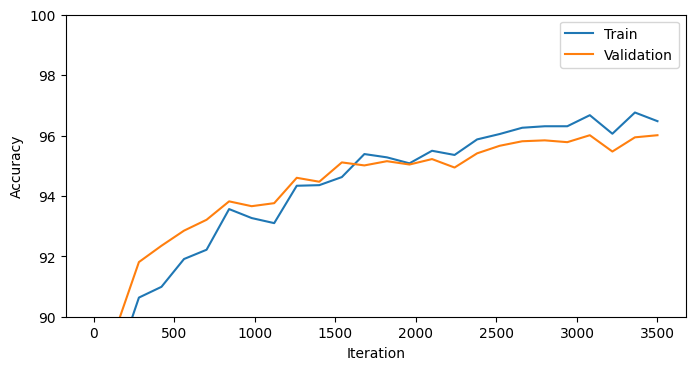

In [45]:
# Create a new student model to start training from zero
small_model = small_linear_net().to(device)
from tqdm import tqdm
%matplotlib inline

# Hyperparameters
lr = 5e-3
epochs = 5
temp = 5

# Create optimizer
optimizer = Adam(small_model.parameters(), lr=lr)
val_acc = []
train_acc = []
train_loss = [0]  # loss at iteration 0
for epoch in range(epochs):
    for features, labels in tqdm(train_loader):
        scores = small_model(features)
        targets = big_model(features)
        loss = my_loss(scores, targets, T = temp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Book-keeping
        if it % 100 == 0:
            train_acc.append(evaluate(small_model, train_loader, max_ex=100))
            val_acc.append(evaluate(small_model, val_loader))
        it += 1
#perform last book-keeping
train_acc.append(evaluate(small_model, train_loader, max_ex=100))
val_acc.append(evaluate(small_model, val_loader))
plot_acc(train_acc, val_acc, it, it_per_epoch)

In [46]:
train_acc = evaluate(small_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(small_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(small_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 96.85%
Validation accuracy: 96.01%
Test accuracy: 96.03%
